In [ ]:
# Enumerated solution, full ODE solved and then macrostates backed out from the population vector at each time


In [1]:
import math
import numpy as np
import nupack4
from nupack4 import State, Model
import scipy.stats
#from nupack4.kinetics import Sim_Timer

ModuleNotFoundError: No module named 'nupack4'

In [ ]:
t = nupack4.kinetics.small_box([nupack4.State('GCGUCGCGUCGCUAUGC',  kind='slow')]*10, 0.00001, 0.425, 100, 200)

In [13]:
macro_States = ['((...))..........', '((.(.((...)).).))', '((((......))).....']

In [ ]:
# Code to find Pair probability matrices for random trajectories from specific initial state
class Stop_Condition:
    def __init__(self, stop_time):
        self.time = 0.0
        self.states = []
        self.timesteps = []
        self.stop_time = stop_time

    def __call__(self, state, timestep):
        self.time += timestep
        self.states.append(state.dp)
        self.timesteps.append(timestep)
        return self.time >= self.stop_time

VigraSafnari = {}   # translation: VectorsCollector
FylkjaSafnari = {}   # translation: RallyCollector (?)

from nupack4.kinetics import Sim_Timer
from functools import partial
from multiprocessing.pool import ThreadPool as Pool
#from multiprocessing import Pool

p = Pool(4)
    
def fn(timeToStop, i):
    Define_State = State('GCGUCGCGUCGCUAUGC', '((...))..........', kind='slow') 
    w = Define_State
    w.run(Sim_Timer(time=timeToStop))
    return structure_matrix(w.dp)

for timeToStop in np.arange(0, 10e-6, 2e-6):
    results = tuple(map(partial(fn, timeToStop), [None] * 10))    # Ath p.map, taka af ef thetta gengur ekki
    
    FylkjaSafnari[timeToStop] = sum(results) / len(results)

In [9]:
################################## Latest working trajectory ############################################ 

class Stop_Condition:
    def __init__(self, stop_time):
        self.time = 0.0
        self.states = []
        self.timesteps = []
        self.stop_time = stop_time

    def __call__(self, state, timestep):
        self.time += timestep
        self.states.append(state.dp)
        self.timesteps.append(timestep)
        return self.time >= self.stop_time
    
class Integrator: 
        def __init__(self, observable):
            self.observable = observable
            self.integral = 0.0
            self.total_time = 0.0

        def __call__(self, state, timestep):
            self.integral = self.integral + self.observable(state) * timestep
            self.total_time += timestep

        def result(self):
            return self.integral / self.total_time

class Structure_Matrix_Observable:
    def __init__(self):
        pass
    
    def __call__(self, state):
        return structure_matrix(state.dp)
    
    
obs = Integrator(Structure_Matrix_Observable())

State_collector = {}
PP_matrix_collector = {}


for timeToStop in np.arange(0, 200e-6, 1e-6):
    State_vec = []
    PP_vec = []
    for i in range(100):
        mod = Model(dangles='none',gt = True)
        Define_State = State('GUCGCGUCGCGUCGCUAUGCGAC', kind='slow', model=mod) 
        w = Define_State
        #w.run(Stop_Condition( float(timeToStop)), observers=[obs])
        w.run(Stop_Condition(float(timeToStop)))
        State_vec.append(w)
        #PP_vec.append(obs.result())
        PP_vec.append( pair_probability('GUCGCGUCGCGUCGCUAUGCGAC',w.dp))
    State_collector[timeToStop] = State_vec
    PP_matrix_collector[timeToStop] = PP_vec
    


In [14]:
PP_matrix_collector
macro_States = ['..(((...)))((((...)))).', '...((...))(((((...)))))','..........(((((...)))))', '(((((((.((...)).)))))))','.....((((((......))))))']
seq = 'GUCGCGUCGCGUCGCUAUGCGAC'
TimeCollector = change_to_macro(PP_matrix_collector, macro_States, seq)

In [11]:
seq = 'GCGUCGCGUCGCUAUGC'
def change_to_macro(PP_matrix_collector, macro_States, seq):
    P_2 = {}
    
    for k in range(len(macro_States)):
        P_2[k] = pair_probability(seq, macro_States[k])
    
    TimeCollector = []
    for i in PP_matrix_collector: #hver timi
        vec_counter = np.zeros(len(macro_States))
        for j in range(len(PP_matrix_collector[i])):         #hver itrun, hvert fylki
            P_1 = PP_matrix_collector[i][j]
            diff_vec = np.zeros(len(macro_States))
            for k in range(len(P_2)):
                diff_vec[k] = np.linalg.norm((P_1 - P_2[k]), ord=1)
            vec_counter[np.argmin(diff_vec)] += 1
        TimeCollector.append(vec_counter)    
           
    return TimeCollector

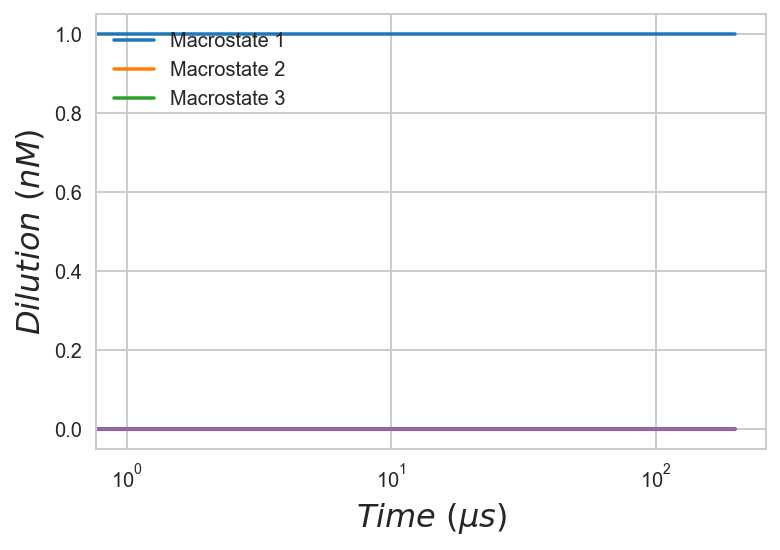

In [16]:
# Draw the population of macrostate at each point by assessment of closest PP matrix

import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

t = np.arange(0, 60, 1e-6)


# Puts up a basis
fig, ax = plt.subplots(1, 1)
# Defines axes
ax.set_xlabel(r'$Time \ ( \mu s )$')
ax.set_ylabel(r'$Dilution \ (nM)$');

dis = {}
for i in range(len(TimeCollector[0])):
    dis[i] = []
        
for j in range(len(TimeCollector)):    
    for i in range(len(TimeCollector[0])):
        dis[i].append(TimeCollector[j][i])

for i in range(len(dis)):
    _ = ax.plot(t, dis[i]/sum(TimeCollector[i]))
ax.set_xscale('log')
ax.legend(('Macrostate 1', 'Macrostate 2', 'Macrostate 3'), loc='upper left');



In [ ]:
# Finding average of Pair Probability at each time from
PP_average = np.zeros(len(PP_matrix_collector))
for i in PP_matrix_collector: #hver timi
    sum_temp = 0
    for j in range(len(PP_matrix_collector[i])):
        sum_temp += PP_matrix_collector[i][j]
    PP_average[i] = sum_temp/(len(PP_matrix_collector[i]))

In [13]:
# Function that takes in a sequence and its dotprint (on sting form) and gives out the pair probability matrix 
#for the stop condtion time.
def pair_probability(seq, w_macro):
    class Integrator:
        def __init__(self, observable):
            self.observable = observable
            self.integral = 0.0
            self.total_time = 0.0

        def __call__(self, state, timestep):
            self.integral = self.integral + self.observable(state) * timestep
            self.total_time += timestep

        def result(self):
            return self.integral / self.total_time

    class Structure_Matrix_Observable:
        def __init__(self):
            pass

        def __call__(self, state):
            return structure_matrix(state.dp)

    obs = Integrator(Structure_Matrix_Observable())
    class Stop_Condition:
        def __init__(self, stop_time):
            self.time = 0.0
            self.states = []
            self.timesteps = []
            self.stop_time = stop_time

        def __call__(self, state, timestep):
            self.time += timestep
            self.states.append(state.dp)
            self.timesteps.append(timestep)
            return self.time >= self.stop_time

    mod = Model(dangles='none',gt = True)
    w = State(seq, w_macro, model = mod)
    w.run(Stop_Condition(0), observers=[obs])
    return obs.result()

In [8]:
# Gives out structure matrix for dotprint on sting form
def structure_matrix(seq):
    lengd = len(seq)
    leftB = []
    rightB = []
    Smatrix = np.zeros([lengd,lengd])
    
    for i in range(lengd):
        if seq[i] == '(':
            leftB.append(i)
        elif seq[i] == ')':
            rightB.append(i)
        
    for x,y in list(enumerate(leftB)):
        Smatrix[y,rightB[len(rightB)-1-x]] = 1
        Smatrix[rightB[len(rightB)-1-x], y] = 1
    Smatrix += np.diag(1-Smatrix.sum(0))
    return Smatrix

In [122]:
macro_States = ['((...))..........', '((.(.((...)).).))', '(((......))).....']
KK = pair_probability('GCGUCGCGUCGCUAUGC', '((...))..........')

In [20]:
for k in range(len(TimeCollector)):
    print(TimeCollector[k])


[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.    0.    0.    0.    0.]
[ 100.  